In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\NCI Cell Lines\\Paclitaxel_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,Paclitaxel
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,5.573385
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,6.502923


In [3]:
#drop the target drug column
drug = data.pop('Paclitaxel')

In [4]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [5]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [6]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [7]:
X.shape, y.shape

((49, 2181), (49,))

In [8]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    28
1    21
dtype: int64

In [9]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [10]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,PIP2(16:0/18:1(11Z)) ; PIP2(16:0/18:1(9Z)) ; PIP2(16:1(9Z)/18:0) ; PIP2(18:0/16:1(9Z)) ; PIP2(18:1(11Z)/16:0) ; PIP2(18:1(9Z)/16:0),"TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z))
0,0.128508,-0.503017,0.110877,0.112983,1.337936,2.270788,1.788266,-1.424172,-0.570163,-0.573070,...,0.367666,-0.148499,0.479093,0.165535,0.080785,0.782414,0.375113,-0.450987,0.056953,0.117214
1,-1.104297,-0.334979,-0.966869,-0.861565,-0.387715,-0.795778,-0.027833,-0.790529,-0.213558,-0.809724,...,-0.779017,-0.452463,-0.701322,-1.119310,-1.823926,-1.100624,-0.470805,-1.765386,-1.532685,-0.318169


In [11]:
X.shape, y.shape

((56, 2181), (56,))

In [12]:
y.value_counts()

1    28
0    28
dtype: int64

In [13]:
X.shape

(56, 2181)

In [14]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.33, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [15]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced', random_state = i)
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define the machine learning model and train it
    model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced', random_state = i)
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 477
Number of features selected during iteration 1: 460
Number of features selected during iteration 2: 456
Number of features selected during iteration 3: 466
Number of features selected during iteration 4: 445
Number of features selected during iteration 5: 441
Number of features selected during iteration 6: 452
Number of features selected during iteration 7: 450
Number of features selected during iteration 8: 462
Number of features selected during iteration 9: 431
Number of features selected during iteration 10: 469
Number of features selected during iteration 11: 476
Number of features selected during iteration 12: 465
Number of features selected during iteration 13: 444
Number of features selected during iteration 14: 448
Number of features selected during iteration 15: 443
Number of features selected during iteration 16: 473
Number of features selected during iteration 17: 456
Number of features selected during iteration 18: 443
Num

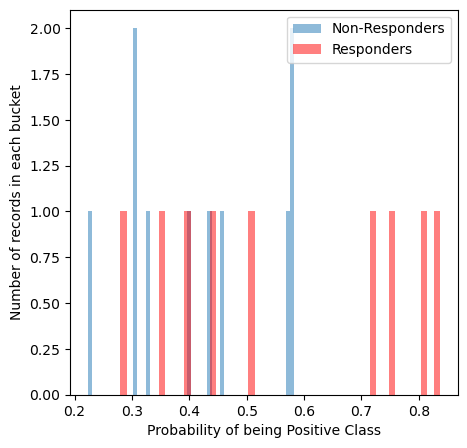

In [16]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [17]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [18]:
df1

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target
0,0.128508,-0.503017,0.110877,0.112983,1.337936,2.270788,1.788266,-1.424172,-0.570163,-0.573070,...,0.479093,0.165535,0.080785,0.782414,0.375113,-0.450987,0.056953,0.117214,NaN,NaN
1,-1.104297,-0.334979,-0.966869,-0.861565,-0.387715,-0.795778,-0.027833,-0.790529,-0.213558,-0.809724,...,-0.701322,-1.119310,-1.823926,-1.100624,-0.470805,-1.765386,-1.532685,-0.318169,NaN,NaN
2,1.134080,-0.467934,2.496178,2.462674,0.825319,0.016559,0.380980,-0.288260,-0.574064,-0.846480,...,0.007713,-0.554557,0.085185,-1.174107,0.570625,0.026136,-0.147366,0.205551,NaN,NaN
3,-1.328527,-0.621086,-1.658035,-1.526733,-1.533967,-1.115362,-0.880554,1.158429,0.066886,-0.230304,...,0.943080,-0.081562,-0.486552,1.209569,-0.459250,-0.505347,0.079821,0.259952,0.438133,1.0
4,-0.871498,-1.200047,-0.086785,-0.089902,-1.558227,-0.783598,-0.132077,0.267215,-0.128228,-0.554116,...,0.217498,-1.808228,-1.431712,-0.843122,-1.270143,-1.657831,-1.690434,-0.376729,NaN,NaN
5,-1.045959,0.450935,-1.231760,-1.184511,-0.231306,-0.399419,0.052819,0.062893,-0.134972,1.515914,...,-0.201595,-1.084089,-0.455485,-0.686474,-0.261461,-0.126484,-1.186204,-0.661018,0.324267,0.0
6,-1.657224,-0.873348,-0.402223,-0.380843,-0.070751,-0.040189,-0.027833,-0.253317,0.416545,-0.379662,...,-0.361744,-0.544943,-0.705713,0.889952,0.437890,-0.722713,-0.525154,1.073300,0.579467,0.0
7,-0.043631,0.605175,-1.585982,-1.584851,-2.132381,-0.040189,-0.027833,0.333622,0.054596,-0.749176,...,1.527510,-1.579393,-1.798193,-1.867401,-2.030864,-2.450390,-1.724567,-2.050887,NaN,NaN
8,-0.110476,-1.120619,0.225099,0.242520,-0.951208,-0.319444,0.014333,-1.155046,-0.626745,-1.158097,...,-0.343433,0.115198,0.449399,-0.390854,0.474941,0.270651,0.318283,0.822009,NaN,NaN
9,0.807286,-0.385747,1.354602,1.362119,2.338758,1.983155,1.509418,-0.967925,0.466410,-0.026330,...,0.939375,0.221868,0.497935,0.160985,0.686536,0.271632,0.049665,0.906513,NaN,NaN


In [19]:
df1_main = df1.iloc[:49, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(1, 2183)

In [20]:
df1_main.index.values #0 40 41 42

array([19], dtype=int64)

In [21]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store accuracy, precision and recall 
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = SVC(kernel = 'linear', C=1, gamma=1, probability = True, random_state = i)
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.coef_.ravel()
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define the SVM model and train it
    model2 = SVC(C=1, gamma=1, probability=True, random_state = i)
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 2181
Features selected during iteration 1: 2181
Features selected during iteration 2: 2181
Features selected during iteration 3: 2181
Features selected during iteration 4: 2181
Features selected during iteration 5: 2181
Features selected during iteration 6: 2181
Features selected during iteration 7: 2181
Features selected during iteration 8: 2181
Features selected during iteration 9: 2181
Features selected during iteration 10: 2181
Features selected during iteration 11: 2181
Features selected during iteration 12: 2181
Features selected during iteration 13: 2181
Features selected during iteration 14: 2181
Features selected during iteration 15: 2181
Features selected during iteration 16: 2181
Features selected during iteration 17: 2181
Features selected during iteration 18: 2181
Features selected during iteration 19: 2181
Features selected during iteration 20: 2181
Features selected during iteration 21: 2181
Features selected during iteration 22: 218

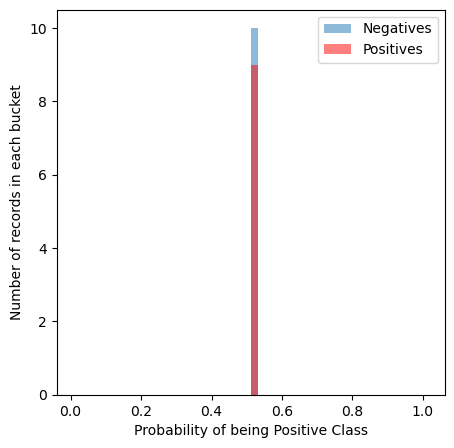

In [22]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [23]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [24]:
df2_main = df2.iloc[:49, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target


In [25]:
df2_main.index.values #40 41 42

array([], dtype=int64)

In [26]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier(seed = i)
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define XGBoost model and train it
    model3 = XGBClassifier(seed = i)
    model3.fit(X_train, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 22
Features selected during iteration 1: 22
Features selected during iteration 2: 22
Features selected during iteration 3: 22
Features selected during iteration 4: 22
Features selected during iteration 5: 22
Features selected during iteration 6: 22
Features selected during iteration 7: 22
Features selected during iteration 8: 22
Features selected during iteration 9: 22
Features selected during iteration 10: 22
Features selected during iteration 11: 22
Features selected during iteration 12: 22
Features selected during iteration 13: 22
Features selected during iteration 14: 22
Features selected during iteration 15: 22
Features selected during iteration 16: 22
Features selected during iteration 17: 22
Features selected during iteration 18: 22
Features selected during iteration 19: 22
Features selected during iteration 20: 22
Features selected during iteration 21: 22
Features selected during iteration 22: 22
Features selected during iteration 23: 22
Fe

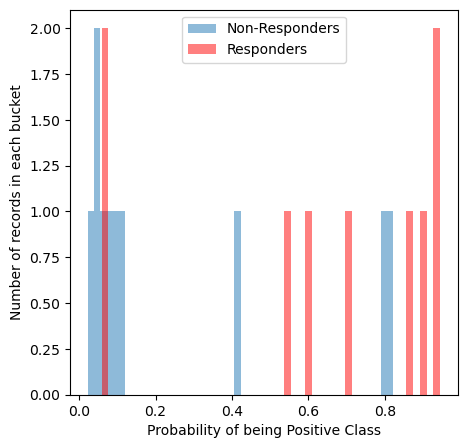

In [27]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [28]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target
0,0.128508,-0.503017,0.110877,0.112983,1.337936,2.270788,1.788266,-1.424172,-0.570163,-0.573070,...,0.479093,0.165535,0.080785,0.782414,0.375113,-0.450987,0.056953,0.117214,NaN,NaN
1,-1.104297,-0.334979,-0.966869,-0.861565,-0.387715,-0.795778,-0.027833,-0.790529,-0.213558,-0.809724,...,-0.701322,-1.119310,-1.823926,-1.100624,-0.470805,-1.765386,-1.532685,-0.318169,NaN,NaN
2,1.134080,-0.467934,2.496178,2.462674,0.825319,0.016559,0.380980,-0.288260,-0.574064,-0.846480,...,0.007713,-0.554557,0.085185,-1.174107,0.570625,0.026136,-0.147366,0.205551,NaN,NaN
3,-1.328527,-0.621086,-1.658035,-1.526733,-1.533967,-1.115362,-0.880554,1.158429,0.066886,-0.230304,...,0.943080,-0.081562,-0.486552,1.209569,-0.459250,-0.505347,0.079821,0.259952,0.548729,1.0
4,-0.871498,-1.200047,-0.086785,-0.089902,-1.558227,-0.783598,-0.132077,0.267215,-0.128228,-0.554116,...,0.217498,-1.808228,-1.431712,-0.843122,-1.270143,-1.657831,-1.690434,-0.376729,NaN,NaN
5,-1.045959,0.450935,-1.231760,-1.184511,-0.231306,-0.399419,0.052819,0.062893,-0.134972,1.515914,...,-0.201595,-1.084089,-0.455485,-0.686474,-0.261461,-0.126484,-1.186204,-0.661018,0.050921,0.0
6,-1.657224,-0.873348,-0.402223,-0.380843,-0.070751,-0.040189,-0.027833,-0.253317,0.416545,-0.379662,...,-0.361744,-0.544943,-0.705713,0.889952,0.437890,-0.722713,-0.525154,1.073300,0.821895,0.0
7,-0.043631,0.605175,-1.585982,-1.584851,-2.132381,-0.040189,-0.027833,0.333622,0.054596,-0.749176,...,1.527510,-1.579393,-1.798193,-1.867401,-2.030864,-2.450390,-1.724567,-2.050887,NaN,NaN
8,-0.110476,-1.120619,0.225099,0.242520,-0.951208,-0.319444,0.014333,-1.155046,-0.626745,-1.158097,...,-0.343433,0.115198,0.449399,-0.390854,0.474941,0.270651,0.318283,0.822009,NaN,NaN
9,0.807286,-0.385747,1.354602,1.362119,2.338758,1.983155,1.509418,-0.967925,0.466410,-0.026330,...,0.939375,0.221868,0.497935,0.160985,0.686536,0.271632,0.049665,0.906513,NaN,NaN


In [29]:
df3_main = df3.iloc[:49, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target
19,-0.330728,-1.582256,0.878873,0.884549,1.420402,1.584938,2.11028,-1.14244,-1.001832,-1.138303,...,0.184805,-0.15617,0.54316,-0.354618,-0.194475,-0.421885,0.071993,0.134587,0.94226,1.0


In [30]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [31]:
cl = set(common_list)
cl

{19}

In [32]:
df1_total = df1.loc[:49, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,Acrylamide,...,"2,4,7,10-hexadecatetraenoylcoa ; 2,7,10,13-hexadecatetraenoylcoa ; 2E,4Z,7Z,10Z-hexadecatetraenoyl-CoA ; 3,7,10,13-hexadecatetraenoylcoa ; 4,7,10,13-hexadecatetraenoylcoa",O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-_6-deoxy-a-L-galactopyranosyl-(1->4)_-O-b-D-galactopyranosyl-(1->4)-O-_6-deoxy-a-L-galactopyranosyl-(1->3)_-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso6_ ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))_iso3_","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),test_proba,target
3,-1.328527,-0.621086,-1.658035,-1.526733,-1.533967,-1.115362,-0.880554,1.158429,0.066886,-0.230304,...,0.943080,-0.081562,-0.486552,1.209569,-0.459250,-0.505347,0.079821,0.259952,0.438133,1.0
13,1.417746,0.260982,-0.761079,-0.680242,-0.524002,-0.930282,-1.159270,-0.794247,1.935498,1.676698,...,-0.834963,-0.382334,-0.049805,-0.403974,-0.374242,0.179284,-0.221490,-0.226304,0.279600,1.0
19,-0.330728,-1.582256,0.878873,0.884549,1.420402,1.584938,2.110280,-1.142440,-1.001832,-1.138303,...,0.184805,-0.156170,0.543160,-0.354618,-0.194475,-0.421885,0.071993,0.134587,0.716667,1.0
22,-1.316280,1.205971,0.810918,0.809577,0.236398,0.748235,0.469483,-0.381609,0.983782,0.054222,...,0.360533,0.229204,0.590961,1.357209,-0.485764,-0.093901,-0.093479,-0.627110,0.394133,1.0
40,-0.287385,1.809596,-1.148345,-1.113244,-0.679483,-1.023633,-0.595809,0.350119,1.181818,-0.655925,...,-1.260264,-1.205761,-1.066127,-1.272363,-1.201070,-1.246630,-1.079566,-1.232113,0.346667,1.0
44,-0.347931,-0.275500,1.449664,1.300522,-0.103190,-0.697333,-0.632442,1.454183,-0.622195,-0.440673,...,-0.088304,-0.386800,-0.559546,1.180201,-1.227928,-0.560502,-0.427879,-1.058027,0.506667,1.0


In [33]:
with open('master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [34]:
l = []
l.extend(df1_total.index.values)
with open('total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')